# MCMC Parameter Estimation for Flat ΛCDM using DESI Data

This notebook derives the cosmological parameters for a **Flat ΛCDM** model by minimizing the chi-square function using only DESI data.

- **Model:** Flat ΛCDM
- **Data:** DESI BAO measurements
- **Method:**
  - Uses the [`CosmologicalDistances`](../../pyACC/cosmology/distances.py) class from the `pyACC` library
  - Uses the [`FlatLambdaCDM`](../../pyACC/cosmology/cosmology.py) class from the `pyACC` library
  - Will use the `emcee` library to perform Markov Chain Monte Carlo (aka _Goodman & Weare_) sampling of the posterior distribution for the parameters $H_0 \times r_d$ and $\Omega_m$, given the DESI data

> **Note:** With DESI data alone, only the product $H_0 \cdot r_d$ can be constrained, not $H_0$ and $r_d$ separately.

In [1]:
import sys
sys.path.append('/home/giorgio/Documents/Scuola/Università/Università_di_Genova/IV_ANNO/II_Semestre/Astrofisica Computazionale/ESAME/ToloAstroCosmoLib')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyACC.cosmology.cosmology import FlatLambdaCDM
from pyACC.cosmology.distances import CosmologicalDistances

# I load DESI data
file_data = "data.csv"
data = pd.read_csv(file_data)
data = data.astype(float)

z = data["z_eff"].values
D_V_over_r_d = data["D_V / r_d"].values
D_V_over_r_d_err = data["D_V / r_d_err"].values

In [2]:
# I define the log-likelihood function for H0*r_d and Omega_m
def log_likelihood(params):
    H0rd, Omega_m = params
    # Reasonable bounds for H0*r_d and Omega_m
    if not (8000 < H0rd < 13000 and 0 < Omega_m < 1):
        return -np.inf  # enforce bounds
    
    # For each sample, I need to choose a value for r_d to compute H0.
    r_d_fid = 147.05 # [Mpc], a fiducial value for the sound horizon at recombination.
    H0 = H0rd / r_d_fid
    model = FlatLambdaCDM(H0, Omega_m)
    distances = CosmologicalDistances(model.H)
    D_V_model = np.array([distances.volume_distance(z_i) for z_i in z])
    # The model prediction for D_V / r_d is D_V_model / r_d_fid
    return -0.5 * np.sum(((D_V_over_r_d - D_V_model / r_d_fid) / D_V_over_r_d_err) ** 2)

# The Monte Carlo Markov Chain(s)

I will use the `emcee` library to perform Markov Chain Monte Carlo (MCMC) sampling of the posterior distribution for the parameters $H_0 \times r_d$ and $\Omega_m$, given the DESI data. The `emcee` library uses multiple, parallel markov chains that run simultaneously aka *Goodman & Weare* sampler.

In [3]:
# I set up the MCMC sampler using the emcee library
import emcee

ndim = 2              # Number of free parameters: H0*r_d, Omega_m
nwalkers = 5 * ndim   # Number of parallel chains
nsteps = 200000       # Number of steps per chain
radius = 3            # Spread of the initial walkers around the initial guess

# Initial guess and spread for walkers
# The walkers all start in a Ball around the initial guess
initial = np.array([60.0 * 147.0, 0.7])  # H0*r_d, Omega_m 
positions = initial + 1e-2 * np.abs(initial) * radius * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood)
sampler.run_mcmc(positions, nsteps, progress=True)

100%|██████████| 200000/200000 [14:05<00:00, 236.58it/s]


State([[1.01650092e+04 2.96252418e-01]
 [1.01245319e+04 3.01656555e-01]
 [9.98566374e+03 3.16547306e-01]
 [1.01087667e+04 3.01070511e-01]
 [1.02060876e+04 2.85541517e-01]
 [1.01801353e+04 3.00900739e-01]
 [1.00274239e+04 3.14481191e-01]
 [1.00435579e+04 3.08572904e-01]
 [1.02148320e+04 2.88843665e-01]
 [1.02814208e+04 2.78784923e-01]], log_prob=[-2.33110254 -2.36182684 -4.09534308 -2.60298559 -3.77941595 -4.00230375
 -3.1758454  -3.30701765 -2.61659297 -3.75614885], blobs=None, random_state=('MT19937', array([1382045559,  867947060, 2216305163, 2625099224, 1211890710,
       1567064537, 3754564168, 3660878120, 1534817584, 3706264008,
       2244486785, 1534560424, 3991139045, 2435945959, 2090782022,
       1475216437, 3457033509, 2163718391, 3640125012, 2682489054,
       3717303118, 3494027884,  306575482, 2375444873, 2649220096,
       1386812952,  690196849,  563381813, 3759125664, 1342371681,
        227504905, 2156508080, 1829564929, 1625661106,  243330306,
       1983214353, 4014

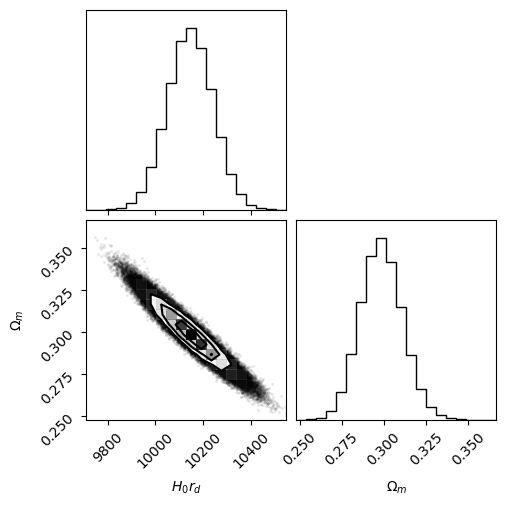

H0*r_d = 10147.27 +94.20 -94.37
Omega_m = 0.299 +0.013 -0.012


In [4]:
# I analyze and plot the results
import corner

samples = sampler.get_chain(discard=500, thin=10, flat=True)
# discard=500: discard the first 500 steps as burn-in
# thin=10:     keep every 10th sample to reduce autocorrelation
# flat=True:   flatten the chain to a 2D array of samples

# Plot the corner plot of the samples
fig = corner.corner(samples, labels=["$H_0 r_d$", r"$\Omega_m$"], truths=initial)
plt.show()

# Print mean and standard deviation for each parameter 
H0rd_mcmc, Omega_m_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                              zip(*np.percentile(samples, [16, 50, 84], axis=0)))
print(f"H0*r_d = {H0rd_mcmc[0]:.2f} +{H0rd_mcmc[1]:.2f} -{H0rd_mcmc[2]:.2f}")
print(f"Omega_m = {Omega_m_mcmc[0]:.3f} +{Omega_m_mcmc[1]:.3f} -{Omega_m_mcmc[2]:.3f}")

## Plot the evolution of each walker's position (trace plots)

These plots show the value of each parameter for every walker as a function of step number. They are useful for diagnosing convergence and mixing of the MCMC chains.

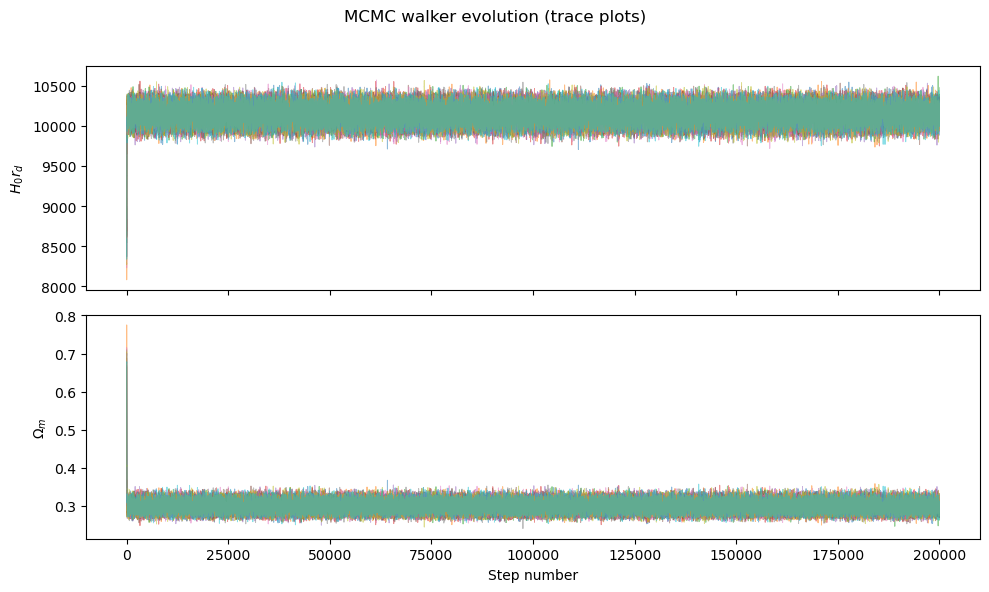

In [5]:
# Plot trace plots for each parameter and walker
chain = sampler.get_chain()  # shape: (nsteps, nwalkers, ndim)
param_labels = [r"$H_0 r_d$", r"$\Omega_m$"]
fig, axes = plt.subplots(ndim, 1, figsize=(10, 6), sharex=True)
for i in range(ndim):
    ax = axes[i]
    for j in range(nwalkers):
        ax.plot(chain[:, j, i], alpha=0.5, lw=0.7)
    ax.set_ylabel(param_labels[i])
axes[-1].set_xlabel("Step number")
fig.suptitle("MCMC walker evolution (trace plots)")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Plot the evolution of each walker's position in parameter space

This plot shows the path of each walker in the ($H_0 r_d$, $\Omega_m$) parameter space as the chain evolves. It is useful for visualizing how the walkers explore the posterior and the burn-in order of magnitude

Text(0, 0.5, '$\\Omega_m$')

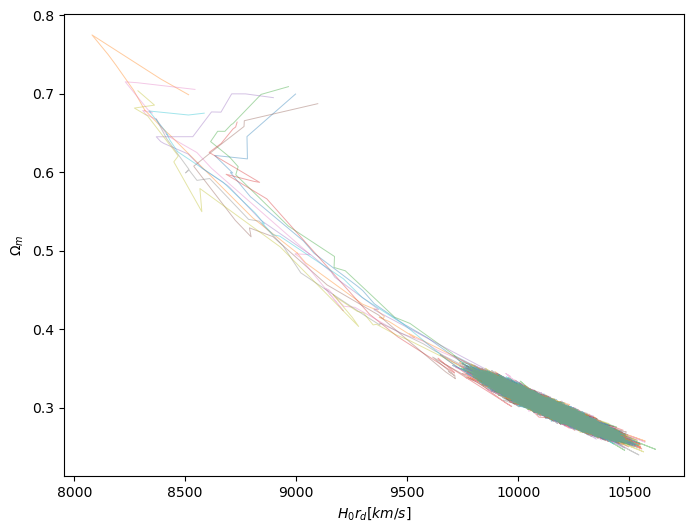

In [6]:
# I plot the evolution of each walker in parameter space
chain = sampler.get_chain()  # shape: (nsteps, nwalkers, ndim)
fig, ax = plt.subplots(figsize=(8, 6))
for j in range(chain.shape[1]):  # for each walker
    ax.plot(chain[:, j, 0], chain[:, j, 1], alpha=0.4, lw=0.7)
ax.set_xlabel(r"$H_0 r_d [km/s]$")
ax.set_ylabel(r"$\Omega_m$")

## Integrated Autocorrelation Time Calculation for Each Chain

For each walker and parameter, we compute the autocorrelation function $C(k)$, the normalized autocorrelation $\rho(k)$, and the integrated autocorrelation time $\tau$ using the formula:

$$\tau = 1 + 2 \sum_{k=1}^{k_{\mathrm{max}}} \rho(k)$$

where $k_{\mathrm{max}}$ is chosen such that $\rho(k)$ drops below zero or a maximum lag.

In [7]:
# I define the functions to compute the autocorrelation time and eventually the effective sample size (ESS)
def autocorr_func_1d(x, max_lag=500):
    n = len(x)
    x = x - np.mean(x)
    result = np.correlate(x, x, mode='full')[n-1:]
    result /= np.arange(n, 0, -1)  # normalization for unbiased estimate
    Ck = result[:max_lag]
    rho_k = Ck / Ck[0]
    return Ck, rho_k

# Only sum positive rho_k until it drops below zero
def integrated_autocorr_time(rho_k):
    positive = rho_k[rho_k > 0]
    return 1 + 2 * np.sum(positive[1:])

# I calculate the autocorrelation time for each walker and each parameter
chain = sampler.get_chain()  
nsteps, nwalkers, ndim = chain.shape
max_lag = 10000

taus = np.zeros((nwalkers, ndim))

for j in range(nwalkers):
    for k in range(ndim):
        x = chain[:, j, k]
        Ck, rho_k = autocorr_func_1d(x, max_lag=max_lag)
        tau = integrated_autocorr_time(rho_k)
        taus[j, k] = tau
        print(f"Walker {j}, Param {k}: tau = {tau:.1f}")

# I print mean and std of tau for each parameter
param_labels = [r"$H_0 r_d$", r"$\Omega_m$"]
for k in range(ndim):
    print(f"Mean tau for {param_labels[k]}: {np.mean(taus[:, k]):.1f} ± {np.std(taus[:, k]):.1f}")

# I print the Effective sample size (ESS) for each parameter
ess = nsteps * nwalkers / taus
for k in range(ndim):
    print(f"Effective sample size (ESS) for {param_labels[k]}: {ess[:, k].mean():.1f} ± {ess[:, k].std():.1f}")
    print(f"ESS for {param_labels[k]}: {ess[:, k].mean():.1f} ± {ess[:, k].std():.1f}")
    

Walker 0, Param 0: tau = 99.6
Walker 0, Param 1: tau = 98.2
Walker 1, Param 0: tau = 97.5
Walker 1, Param 1: tau = 97.4
Walker 2, Param 0: tau = 105.8
Walker 2, Param 1: tau = 101.6
Walker 3, Param 0: tau = 106.1
Walker 3, Param 1: tau = 109.7
Walker 4, Param 0: tau = 109.8
Walker 4, Param 1: tau = 105.5
Walker 5, Param 0: tau = 98.0
Walker 5, Param 1: tau = 96.0
Walker 6, Param 0: tau = 103.8
Walker 6, Param 1: tau = 103.9
Walker 7, Param 0: tau = 97.7
Walker 7, Param 1: tau = 99.9
Walker 8, Param 0: tau = 98.8
Walker 8, Param 1: tau = 94.6
Walker 9, Param 0: tau = 110.3
Walker 9, Param 1: tau = 112.2
Mean tau for $H_0 r_d$: 102.7 ± 4.8
Mean tau for $\Omega_m$: 101.9 ± 5.6
Effective sample size (ESS) for $H_0 r_d$: 19508.8 ± 893.2
ESS for $H_0 r_d$: 19508.8 ± 893.2
Effective sample size (ESS) for $\Omega_m$: 19684.3 ± 1050.3
ESS for $\Omega_m$: 19684.3 ± 1050.3


## Plot the Autocorrelation Function $\rho(k)$ for Each Parameter and Walker

Below, I plot the normalized autocorrelation $\rho(k)$ as a function of lag $k$ for each parameter and a subset of walkers. This helps visualize the correlation structure and mixing of the MCMC chains and to make sure my choice of max_lag (chosen before out of nowhere) is justified

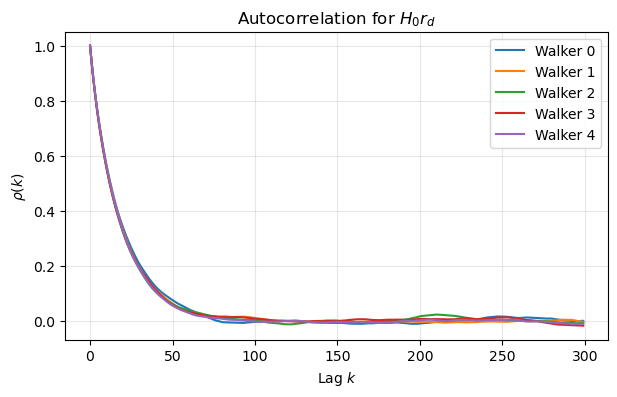

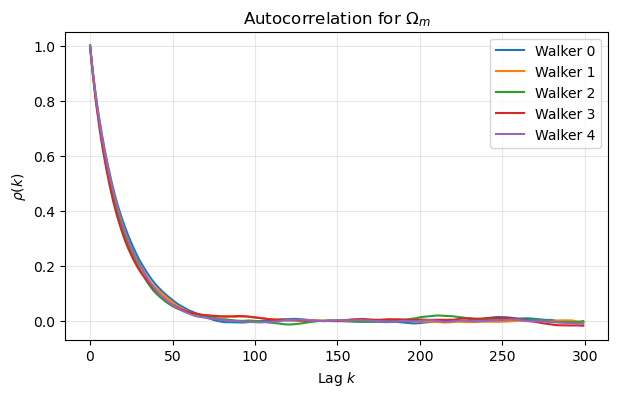

In [8]:
# I plot rho(k) with respect to the lag for each parameter and a few walkers )
max_lag_plot = 300
chain = sampler.get_chain()
nsteps, nwalkers, ndim = chain.shape
param_labels = [r"$H_0 r_d$", r"$\Omega_m$"]

nwalkers_shown = min(nwalkers, 5)  # I plot up to 5 walkers for clarity

import matplotlib.pyplot as plt

for k in range(ndim):
    plt.figure(figsize=(7, 4))
    for j in range(min(nwalkers, 5)):  # plot up to 5 walkers for clarity
        x = chain[:, j, k]
        _, rho_k = autocorr_func_1d(x, max_lag=max_lag_plot)
        plt.plot(np.arange(max_lag_plot), rho_k, label=f'Walker {j}')
    plt.xlabel('Lag $k$')
    plt.ylabel(r'$\rho(k)$')
    plt.title(f'Autocorrelation for {param_labels[k]}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

## Comparison with Literature: arXiv:2411.12020v1

<div style="background: #f6f8fa; border-left: 4px solid #0366d6; padding: 1em 1.5em; margin-bottom: 1em;">
<b>Paper Reference:</b> <a href="https://arxiv.org/abs/2411.12020v1" target="_blank">arXiv:2411.12020v1</a>  
<b>Table V, Flat ΛCDM, DESI-only fit</b>
</div>

| Flat ΛCDM         | My $χ^2$ minimization         |My MCMC sample    | Paper|
|-------------------|-------------------------------|-------------------|----------------------------|
| $H_0 \cdot r_d$   | $10150.52 \pm 1013.37 \,\text{km/s}$   |$10147.20_{-94.55}^{+93.85}\,\text{km/s}$| ~$\,11000 \,\text{km/s}$           |
| $\Omega_m$        | $0.2980 \pm 0.0943$           | $0.2975 \pm 0.0086$       | $0.299_{+0.013}^{-0.012}$|